In [1]:
pip install factor_analyzer -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import factor_analyzer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import FactorAnalysis

## Загрузка данных

In [9]:
PATH_DATA = "../data/pilot_preprocessing.csv"
df = pd.read_csv(PATH_DATA)
y = df['satisfaction']
X = df.drop(columns=['satisfaction'])

In [10]:
# выделим отзывы пассажиров и их удовлетворенность (satisfaction) для проведения факторного анализа
point_columns = ['satisfaction', 'gender',	'age',	'customer_type', 'type_of_travel',	'class',	'flight_distance']
X_point = df.drop(point_columns, axis=1)

X_point.sample(5)

,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness
7519,1,1,1,1,1,1,1,1,3,1,3,2,2,1
94568,4,3,3,3,4,3,4,4,3,4,4,3,5,4
71826,2,5,2,3,3,2,1,3,5,5,4,5,4,3
66862,2,1,1,2,4,1,4,4,4,2,2,2,2,4
71960,5,1,1,1,5,5,5,5,3,4,5,3,1,5


**Целевая переменная**
- `satisfaction`: удовлетворенность клиента полетом, бинарная (*satisfied* или *neutral or dissatisfied*)

**Признаки**
- `Gender` (categorical: _Male_ или _Female_): пол клиента
- `Age` (numeric, int): количество полных лет
- `Customer Type` (categorical: _Loyal Customer_ или _disloyal Customer_): лоялен ли клиент авиакомпании?
- `Type of Travel` (categorical: _Business travel_ или _Personal Travel_): тип поездки
- `Class` (categorical: _Business_ или _Eco_, или _Eco Plus_): класс обслуживания в самолете
- `Flight Distance` (numeric, int): дальность перелета (в милях)
- `Inflight wifi service` (categorical, int): оценка клиентом интернета на борту
- `Departure/Arrival time convenient` (categorical, int): оценка клиентом удобство времени прилета и вылета
- `Ease of Online booking` (categorical, int): оценка клиентом удобства онлайн-бронирования
- `Gate location` (categorical, int): оценка клиентом расположения выхода на посадку в аэропорту
- `Food and drink` (categorical, int): оценка клиентом еды и напитков на борту
- `Online boarding` (categorical, int): оценка клиентом выбора места в самолете
- `Seat comfort` (categorical, int): оценка клиентом удобства сиденья
- `Inflight entertainment` (categorical, int): оценка клиентом развлечений на борту
- `On-board service` (categorical, int): оценка клиентом обслуживания на борту
- `Leg room service` (categorical, int): оценка клиентом места в ногах на борту
- `Baggage handling` (categorical, int): оценка клиентом обращения с багажом
- `Checkin service` (categorical, int): оценка клиентом регистрации на рейс
- `Inflight service` (categorical, int): оценка клиентом обслуживания на борту
- `Cleanliness` (categorical, int): оценка клиентом чистоты на борту

## Поверхностный анализ

Сперва посмотрим на матрицу корреляций между признаками. Основная гипотеза: некоторые оценки перекликаются между собой. Вместо снижения размерности PCA хотелось попробовать разделить признаки осмысленно - провести факторный анализ.

Для этого в матрице корреляций признаки должны коррелировать группами друг с другом.

In [11]:
X_point.corr().style.background_gradient()

,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness
inflight_wifi_service,1.000000,0.343625,0.715502,0.335856,0.134522,0.456616,0.122386,0.209469,0.121461,0.160108,0.120989,0.042399,0.110397,0.132851
departure/arrival_time_convenient,0.343625,1.000000,0.436670,0.443588,0.004860,0.070043,0.010967,-0.004981,0.068360,0.012221,0.071337,0.092793,0.072768,0.014132
ease_of_online_booking,0.715502,0.436670,1.000000,0.458290,0.032044,0.403616,0.029444,0.047495,0.038569,0.107154,0.038521,0.010535,0.035200,0.016086
gate_location,0.335856,0.443588,0.458290,1.000000,-0.000935,0.001121,0.002568,0.003199,-0.029474,-0.006024,0.001901,-0.036437,0.000917,-0.004111
food_and_drink,0.134522,0.004860,0.032044,-0.000935,1.000000,0.234687,0.574184,0.621952,0.058393,0.031910,0.034300,0.086368,0.034133,0.657245
online_boarding,0.456616,0.070043,0.403616,0.001121,0.234687,1.000000,0.420374,0.285161,0.154947,0.123848,0.082925,0.203450,0.074335,0.331343
seat_comfort,0.122386,0.010967,0.029444,0.002568,0.574184,0.420374,1.000000,0.610084,0.131742,0.105465,0.073826,0.191378,0.069073,0.677719
inflight_entertainment,0.209469,-0.004981,0.047495,0.003199,0.621952,0.285161,0.610084,1.000000,0.419514,0.299300,0.377361,0.120331,0.404762,0.691269
on-board_service,0.121461,0.068360,0.038569,-0.029474,0.058393,0.154947,0.131742,0.419514,1.000000,0.355637,0.519055,0.243647,0.550414,0.122773
leg_room_service,0.160108,0.012221,0.107154,-0.006024,0.031910,0.123848,0.105465,0.299300,0.355637,1.000000,0.369210,0.152175,0.368343,0.095942


По оценкам можно выделить

- любителей комфорта(чистота, еда/напитки, комфорт сиденья, развлечения на борту)

- требовательных, которых нужно обслуживать (обслуживание на борту, обращение с багажом, , обслуживание на борту_2)

- любителей интернета и пунктуальности (wifi, удобство онлайн бронирования, время прилета/отлета, удобство посадки на)

По категориальным можно выделить

- бизнесменов (класс бизнес, следовательно поездка тоже дороже)

- также дальность перелета немного коррелирует с классом (чем дальше летят, тем больше тратят) значит есть любители полетать недалеко и дешево и далеко и дорого.


In [5]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [6]:
chi,p_value=calculate_bartlett_sphericity(X_point)
chi,p_value

(589789.4498466988, 0.0)

In [12]:
kmo_all, kmo_model = calculate_kmo(X_point)
print("Критерий Кайзера общий - ", kmo_model)
for col_x, kmo_x in zip(X_point.columns, kmo_all):
  print(col_x, "\t", kmo_x)

Критерий Кайзера общий -  0.7812357654614928
inflight_wifi_service 	 0.7419509219851858
departure/arrival_time_convenient 	 0.7528845983522812
ease_of_online_booking 	 0.681561210948574
gate_location 	 0.7067840597397468
food_and_drink 	 0.8409389087005157
online_boarding 	 0.7364812082403536
seat_comfort 	 0.8325528838821423
inflight_entertainment 	 0.7682056088012267
on-board_service 	 0.8288592506583753
leg_room_service 	 0.8897792389457969
baggage_handling 	 0.8144034603875241
checkin_service 	 0.7001958683857135
inflight_service 	 0.7841113870957639
cleanliness 	 0.816938010433545


Критерий Баклера = 0, а КМО 0,77 (больше 0,5). Оба этих значения свидетельствуют о разумности проведения кластерного анализа.

У всех параметров кроме гендера и customer_type значения kmo уверенно больше 0,5.


## Предпроцессинг (приведение к одному масштабу для кластерного, факторного и PCA)

In [12]:
scal = MinMaxScaler()
X_scal = pd.DataFrame(scal.fit_transform(X_point), columns=X_point.columns)
X_scal.columns
round_acc=3

## Факторный анализ

### Использование PCA и понимание, сколько дисперсии описывается разным количеством признаков

Text(0, 0.5, 'Процент описываемой дисперсии')

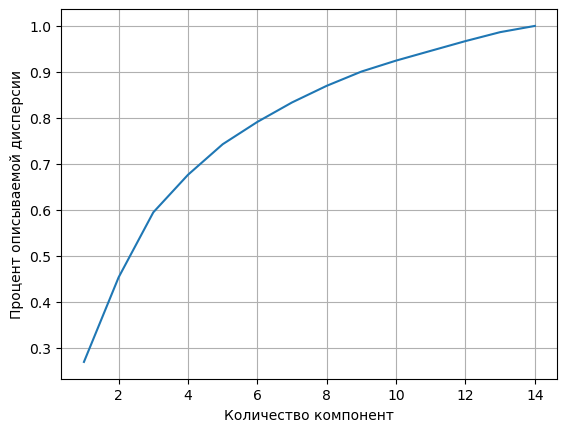

In [15]:
pca=PCA(n_components=len(X_scal.columns))
pca.fit(X_scal)
sum_disp = 0
n_comp, dispersion = [], []
for num_comp, disp_x in enumerate(pca.explained_variance_ratio_):
    sum_disp+=disp_x
    dispersion.append(sum_disp)
    n_comp.append(num_comp+1)
    # print(sum_disp)
plt.plot(n_comp, dispersion)
plt.grid()
plt.xlabel('Количество компонент')
plt.ylabel("Процент описываемой дисперсии")

### Определение количества факторов

In [16]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.fit(X_scal)
eigen_values,vectors=fa.get_eigenvalues()
eigen_values

array([3.7965852 , 2.3610699 , 2.16666916, 1.06285586, 0.95139715,
       0.70035445, 0.54124509, 0.51468265, 0.46943416, 0.36871322,
       0.32912318, 0.29567055, 0.25343168, 0.18876774])

Правило Кайзера гласит, что оптимальное количество компонент то, при котором значения Ейгена больше 1. 

По правилу Кайзера стоит оставить 4 фактора.

Можно попробовать 4 (1,062) (следующий уже 2,166)

Можно попробовать 5 (0,951), но не 6.

Определим наилучшее количество факторов методом Кеттелла (построим график и найдем точки наискорейшего спада графика)

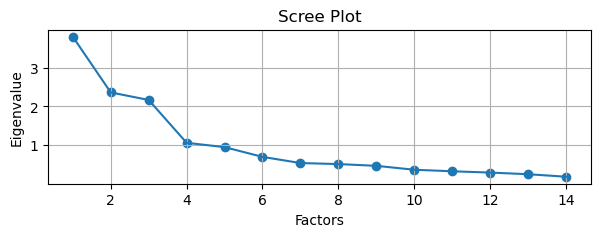

In [17]:
plt.figure(figsize=(7,2))
plt.scatter(range(1,X_scal.shape[1]+1),eigen_values)
plt.plot(range(1,X_scal.shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Строго по правилу получается 4 или 5.

### Факторный анализ

In [18]:
# попробуем для 4х компонент провести факторный анализ
n_fa = 4
fa.set_params(n_factors= n_fa, rotation='varimax')
fa.fit(X_scal)
loadings=pd.DataFrame(fa.loadings_,columns=[f'factor_{i}' for i in range(n_fa)],index=X_scal.columns)
loadings.style.background_gradient()

,factor_0,factor_1,factor_2,factor_3
inflight_wifi_service,0.092930,0.132417,0.607871,0.474704
departure/arrival_time_convenient,-0.006334,0.056579,0.588368,-0.001041
ease_of_online_booking,-0.035773,0.027466,0.768789,0.459459
gate_location,0.012940,-0.045915,0.679246,-0.102220
food_and_drink,0.770112,0.002383,0.033313,0.039622
online_boarding,0.286907,0.118293,0.096437,0.757416
seat_comfort,0.753589,0.078463,-0.028590,0.214549
inflight_entertainment,0.766231,0.464198,0.041737,0.032447
on-board_service,0.087561,0.700397,0.010118,0.051918
leg_room_service,0.057410,0.482968,0.041015,0.096780


ИНТЕРПРЕТАЦИЯ

- 1) любители чистоты, развлечений, комфортных сидений и еды
- 2) любители хорошего сервиса и обращения с багажом
- 3) любители удобно зарегистрироваться, выбрать место, зайти на самолет, вовремя прилететь и быть в сети во время полета
- 4) особо ничего не ценят кроме места в самолете

In [19]:
# попробуем для 5х компонент провести факторный анализ
n_fa = 5
fa.set_params(n_factors= n_fa, rotation='varimax')
fa.fit(X_scal)
loadings=pd.DataFrame(fa.loadings_,columns=[f'factor_{i}' for i in range(n_fa)],index=X_scal.columns)
loadings.style.background_gradient()

,factor_0,factor_1,factor_2,factor_3,factor_4
inflight_wifi_service,0.097516,0.142611,0.672215,0.425334,-0.101289
departure/arrival_time_convenient,-0.013188,0.048436,0.089437,0.671417,0.134337
ease_of_online_booking,-0.032261,0.038848,0.674629,0.586144,-0.095554
gate_location,0.002353,-0.026728,0.086104,0.662801,-0.077880
food_and_drink,0.762208,-0.000925,0.049175,0.020375,-0.022271
online_boarding,0.296710,0.066455,0.696149,-0.050548,0.295486
seat_comfort,0.758555,0.037365,0.147050,-0.029903,0.230429
inflight_entertainment,0.810067,0.498676,0.078382,-0.014513,-0.174904
on-board_service,0.090911,0.686189,0.052054,-0.002690,0.129567
leg_room_service,0.061354,0.482911,0.126951,-0.009733,0.018301


В случае 5ти факторов 3 и 4 разделились на любителей интернета и любителей комфортно заказать и сесть. 5ый файтор получился практически ни о чем (ценит сервис в самолете на 0,45 и выбор места в самолете на 0,29)

- Следует остановиться на 4х факторах, 5 слишком не интерпретируемы

### Преобразование значений df


Преобразуем оценки пользователей с помощью факторного анализа на 4 признака. Затем соберем результирующий набор данных

In [25]:
n_fa = 4
fa.set_params(n_factors= n_fa, rotation='varimax')
fa.fit(X_scal)

factor_columns = ['комфорт, еда, развлечения','сервис/обслуживание', 'интернет сервис', "основные функции"]
X_point_scal_new=pd.DataFrame(fa.fit_transform(X_scal), columns=factor_columns)
scal_new = MinMaxScaler()
X_point_scal_new_scal = pd.DataFrame(scal_new.fit_transform(X_point_scal_new), columns=factor_columns)*5
X_point_scal_new_scal = X_point_scal_new_scal.round()
X_point_scal_new_scal.head()

,"комфорт, еда, развлечения",сервис/обслуживание,интернет сервис,основные функции
0,4.0,4.0,3.0,2.0
1,4.0,4.0,2.0,3.0
2,4.0,2.0,3.0,4.0
3,4.0,4.0,2.0,3.0
4,3.0,2.0,3.0,4.0


In [26]:
result_df = pd.concat([df[point_columns], X_point_scal_new_scal], axis=1)
result_df.head()

,satisfaction,gender,age,customer_type,type_of_travel,class,flight_distance,"комфорт, еда, развлечения",сервис/обслуживание,интернет сервис,основные функции
0,0,1,48,0,1,2,821,4.0,4.0,3.0,2.0
1,1,0,35,1,1,2,821,4.0,4.0,2.0,3.0
2,1,1,41,1,1,2,853,4.0,2.0,3.0,4.0
3,1,1,50,1,1,2,1905,4.0,4.0,2.0,3.0
4,1,0,49,1,1,2,3470,3.0,2.0,3.0,4.0


In [27]:
result_df.shape

(102039, 11)

In [28]:
result_df.to_csv('../data/pilot_prep_factor.csv', index=False)